<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Reseau_GRU_Avec_Auto_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dans ce carnet nous allons mettre en place un modèle à réseau de neurones récurrent de type GRU associé à une **couche d'auto attention** comprenant une **matrice de contexte** pour réaliser des prédictions sur notre série temporelle.  
Ce modèle est tiré du papier de recherche : [A Structured Self-attentive Sentence Embedding](https://arxiv.org/pdf/1703.03130)

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

# Création de la série temporelle et du dataset pour l'entrainement

In [2]:
# Fonction permettant d'afficher une série temporelle
def affiche_serie(temps, serie, format="-", debut=0, fin=None, label=None):
    plt.plot(temps[debut:fin], serie[debut:fin], format, label=label)
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# Fonction permettant de créer une tendance
def tendance(temps, pente=0):
    return pente * temps

# Fonction permettant de créer un motif
def motif_periodique(instants):
    return (np.where(instants < 0.4,                            # Si les instants sont < 0.4
                    np.cos(instants * 2 * np.pi),               # Alors on retourne la fonction cos(2*pi*t)
                    1 / np.exp(3 * instants)))                  # Sinon, on retourne la fonction exp(-3t)

# Fonction permettant de créer une saisonnalité avec un motif
def saisonnalite(temps, periode, amplitude=1, phase=0):
    """Répétition du motif sur la même période"""
    instants = ((temps + phase) % periode) / periode            # Mapping du temps =[0 1 2 ... 1460] => instants = [0.0 ... 1.0]
    return amplitude * motif_periodique(instants)

# Fonction permettant de générer du bruit gaussien N(0,1)
def bruit_blanc(temps, niveau_bruit=1, graine=None):
    rnd = np.random.RandomState(graine)
    return rnd.randn(len(temps)) * niveau_bruit

# Fonction permettant de créer un dataset à partir des données de la série temporelle
# au format X(X1,X2,...Xn) / Y(Y1,Y2,...,Yn)
# X sont les données d'entrées du réseau
# Y sont les labels

def prepare_dataset_XY(serie, taille_fenetre, batch_size, buffer_melange):
  dataset = tf.data.Dataset.from_tensor_slices(serie)
  dataset = dataset.window(taille_fenetre+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(taille_fenetre + 1))
  dataset = dataset.map(lambda x: (x[:-1], x[-1:]))
  dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)
  return dataset


# Création de la série temporelle
temps = np.arange(4 * 365)                # temps = [0 1 2 .... 4*365] = [0 1 2 .... 1460]
amplitude = 40                            # Amplitude de la la saisonnalité
niveau_bruit = 5                          # Niveau du bruit
offset = 10                               # Offset de la série

serie = offset + tendance(temps, 0.1) + saisonnalite(temps, periode=365, amplitude=amplitude) + bruit_blanc(temps,niveau_bruit,graine=40)

temps_separation = 1000

# Extraction des temps et des données d'entrainement
temps_entrainement = temps[:temps_separation]
x_entrainement = serie[:temps_separation]

# Exctraction des temps et des données de valiadation
temps_validation = temps[temps_separation:]
x_validation = serie[temps_separation:]

# Définition des caractéristiques du dataset que l'on souhaite créer
taille_fenetre = 20
batch_size = 32
buffer_melange = 1000

# Création du dataset X,Y
dataset = prepare_dataset_XY(x_entrainement,taille_fenetre,batch_size,buffer_melange)

# Création du dataset X,Y de validation
dataset_Val = prepare_dataset_XY(x_validation,taille_fenetre,batch_size,buffer_melange)

In [3]:
# Calcul de la moyenne et de l'écart type de la série
mean = tf.math.reduce_mean(serie)
std = tf.math.reduce_std(serie)
print(mean.numpy())
print(std.numpy())

# Normalise les données
Serie_Normalisee = (serie-mean)/std
min = tf.math.reduce_min(serie)
max = tf.math.reduce_max(serie)
print(tf.math.reduce_mean(Serie_Normalisee).numpy())
print(tf.math.reduce_std(Serie_Normalisee).numpy())

90.49378905192393
43.81927756886552
2.6736603798507197e-16
1.0


In [4]:
# Création des données pour l'entrainement et le test
x_entrainement_norm = Serie_Normalisee[:temps_separation]
x_validation_norm = Serie_Normalisee[temps_separation:]

# Création du dataset X,Y
dataset_norm = prepare_dataset_XY(x_entrainement_norm,taille_fenetre,batch_size,buffer_melange)

# Création du dataset X,Y de validation
dataset_Val_norm = prepare_dataset_XY(x_validation_norm,taille_fenetre,batch_size,buffer_melange)

# Création du modèle GRU avec couche d'attention possédant un vecteur de contexte

**1. Création du réseau et adaptation des formats d'entrée et de sortie**

Sous forme de shéma, notre réseau est donc le suivant :


<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/Attention_VecteurContexte1.png?raw=true" width="1200"> 

In [ ]:
# Remise à zéro de tous les états générés par Keras
tf.keras.backend.clear_session()

On créé une classe dérivée de la classe [Layer](https://keras.io/api/layers/base_layer/#layer-class) de Keras. Les méthodes utilisées sont les suivantes :  
 - [build](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#build) : Permet de créer les variables utilisées par la couche (commes les poids et les offsets)
 - [call](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#call) : Permet d'implanter la logique de la couche

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/Attention_VecteurContexte2.png?raw=true" width="1200"> 

Parmi les nouvelles fonctions de Tensorflow et de Keras utilisées, on trouve :
- [transpose](https://www.tensorflow.org/api_docs/python/tf/transpose) : Permet de transposer un tenseur et éventuellement de reconstituer l'ordre des axes avec l'argument `perm`
- [add_weight](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#add_weight) : Méthode de la classe Layers de Keras, qui permet d'ajouter un paramètre (poids et offset ou autre) qui sera une variable mémoire pour la couche construite. 


In [5]:
# Classe d'auto-attention
# Applique les poids de la matrice d'attention sur les vecteurs de la couche récurrente

# Importe le Backend de Keras
from keras import backend as K

# Définit une nouvelle classe Couche_Attention
# Héritée de la classe Layer de Keras

class Couche_Auto_Attention(tf.keras.layers.Layer):
  # Fonction d'initialisation de la classe d'attention
  def __init__(self,dim_att,nbr_hop):
    self.dim_att = dim_att          # Dimension du vecteur d'attention
    self.nbr_hop = nbr_hop
    super().__init__()              # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.W = self.add_weight(shape=(self.dim_att,input_shape[2]),initializer="normal",name="W")
    self.U = self.add_weight(shape=(self.nbr_hop,self.dim_att),initializer="normal",name="U")
    super().build(input_shape)        # Appel de la méthode build()

  # Définit la logique de la couche d'attention
  # Arguments :   x : Tenseur d'entrée de dimension (None, nbr_v,dim)
  def call(self,x):
    # Calcul de la matrice XH contenant les
    # représentations cachées des vecteurs
    # issus de la couche GRU
    xt = tf.transpose(x,perm=[0,2,1])         # x = (None, dim,20)
    Xh = K.dot(self.W,xt)                     # Xh = (dim_att,None,20)
    Xh = tf.transpose(Xh,perm=[1,0,2])        # Xh = (None, dim_att,20)
    Xh = K.tanh(Xh)                           # Xh = (None, dim_att,20)

    # Calcul de la matrice des poids d'attention normalisés
    A = K.dot(self.U,Xh)                      # A = (nbr_hop,None,20)
    A = tf.transpose(A,perm=[1,0,2])          # A = (None, nbr_hop,20)
    A = tf.keras.activations.softmax(A,axis=1)

    # Calcul de la matrice des vecteur d'attentions
    sortie = tf.keras.layers.Dot(axes=(2,1))([A,x])         # sortie = (None,nbr_hop,dim_att)
    return tf.keras.layers.Flatten()(sortie)

In [6]:
dim_GRU = 40
nbr_hop = 5

# Fonction de la couche lambda d'entrée
def Traitement_Entrees(x):
  return tf.expand_dims(x,axis=-1)

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(taille_fenetre,)))
model.add(tf.keras.layers.Lambda(Traitement_Entrees))
model.add(tf.keras.layers.GRU(dim_GRU,return_sequences=True))
model.add(Couche_Auto_Attention(dim_GRU,nbr_hop))
model.add(tf.keras.layers.Dense(1))

model.save_weights('model_initial.h5')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 20, 1)             0         
_________________________________________________________________
gru (GRU)                    (None, 20, 40)            5160      
_________________________________________________________________
couche__auto__attention (Cou (None, 200)               1800      
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 7,161
Trainable params: 7,161
Non-trainable params: 0
_________________________________________________________________


**2. Optimisation du taux d'apprentissage**

In [7]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(lr=1e-8)

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur, metrics="mae")

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset_norm,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint])

Epoch 1/100
30/30 [==============================] - 2s 12ms/step - loss: 2.6183 - mae: 3.1052

Epoch 00001: loss improved from inf to 1.70218, saving model to poids.hdf5
Epoch 2/100
30/30 [==============================] - 0s 9ms/step - loss: 2.6183 - mae: 3.1052

Epoch 00002: loss improved from 1.70218 to 1.70216, saving model to poids.hdf5
Epoch 3/100
30/30 [==============================] - 0s 10ms/step - loss: 2.6182 - mae: 3.1051

Epoch 00003: loss improved from 1.70216 to 1.70213, saving model to poids.hdf5
Epoch 4/100
30/30 [==============================] - 0s 9ms/step - loss: 2.6182 - mae: 3.1051

Epoch 00004: loss improved from 1.70213 to 1.70210, saving model to poids.hdf5
Epoch 5/100
30/30 [==============================] - 0s 10ms/step - loss: 2.6181 - mae: 3.1050

Epoch 00005: loss improved from 1.70210 to 1.70205, saving model to poids.hdf5
Epoch 6/100
30/30 [==============================] - 0s 9ms/step - loss: 2.6180 - mae: 3.1049

Epoch 00006: loss improved from 1.70

Text(0.5, 1.0, "Evolution de l'erreur en fonction du taux d'apprentissage")

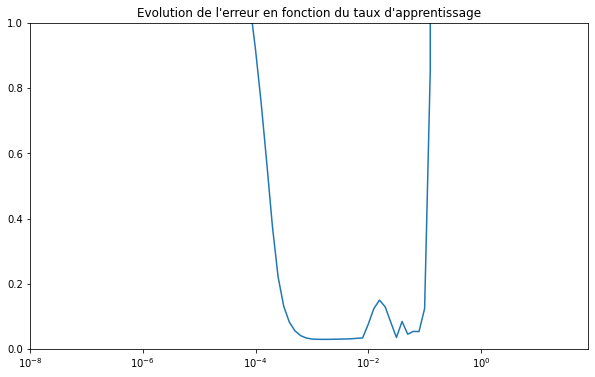

In [8]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[0], taux[99], 0, 1])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

**3. Entrainement du modèle**

In [18]:
# Charge les meilleurs poids
model.load_weights("poids.hdf5")

In [19]:
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

# Définition des paramètres liés à l'évolution du taux d'apprentissage
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.002,
    decay_steps=10,
    decay_rate=0.01/10
    )

cb = TimingCallback()

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(lr=0.0014,momentum=0.9)


# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur,metrics="mae")

# Entraine le modèle
historique = model.fit(dataset_norm,validation_data=dataset_Val_norm, epochs=500,verbose=1, callbacks=[CheckPoint,cb])

print(cb.logs)
print(sum(cb.logs))

Epoch 1/500
30/30 [==============================] - 3s 31ms/step - loss: 0.0402 - mae: 0.2178 - val_loss: 0.0248 - val_mae: 0.1578

Epoch 00001: loss improved from inf to 0.03836, saving model to poids_train.hdf5
Epoch 2/500
30/30 [==============================] - 0s 14ms/step - loss: 0.0556 - mae: 0.2711 - val_loss: 0.0244 - val_mae: 0.1569

Epoch 00002: loss did not improve from 0.03836
Epoch 3/500
30/30 [==============================] - 0s 15ms/step - loss: 0.0387 - mae: 0.2156 - val_loss: 0.0245 - val_mae: 0.1521

Epoch 00003: loss improved from 0.03836 to 0.03672, saving model to poids_train.hdf5
Epoch 4/500
30/30 [==============================] - 0s 14ms/step - loss: 0.0395 - mae: 0.2189 - val_loss: 0.0240 - val_mae: 0.1522

Epoch 00004: loss did not improve from 0.03672
Epoch 5/500
30/30 [==============================] - 0s 15ms/step - loss: 0.0374 - mae: 0.2109 - val_loss: 0.0241 - val_mae: 0.1508

Epoch 00005: loss improved from 0.03672 to 0.03604, saving model to poids_t

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

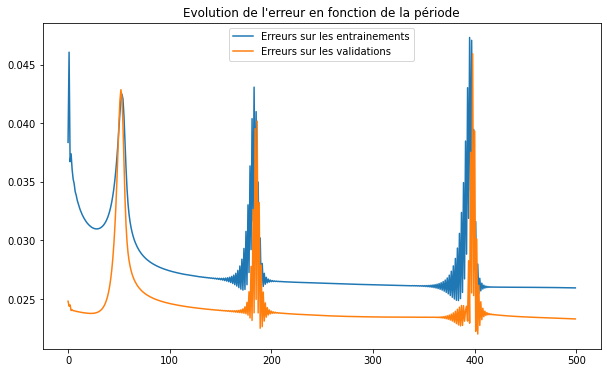

In [20]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

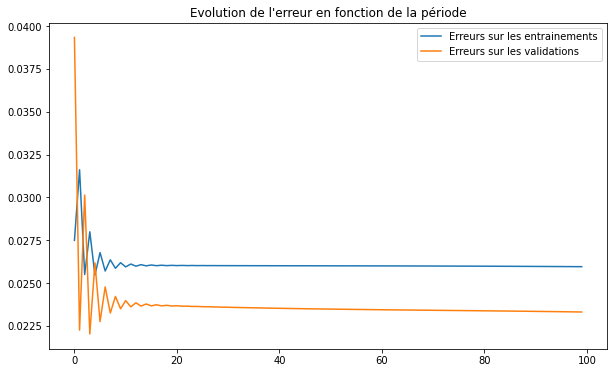

In [21]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_entrainement[400:500], label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_validation[400:500], label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

**4. Prédictions**

In [22]:
taille_fenetre = 20

# Création d'une liste vide pour recevoir les prédictions
predictions = []

# Calcul des prédiction pour chaque groupe de 20 valeurs consécutives de la série
# dans l'intervalle de validation
for t in temps[temps_separation:-taille_fenetre]:
    X = np.reshape(Serie_Normalisee[t:t+taille_fenetre],(1,taille_fenetre))
    predictions.append(model.predict(X))

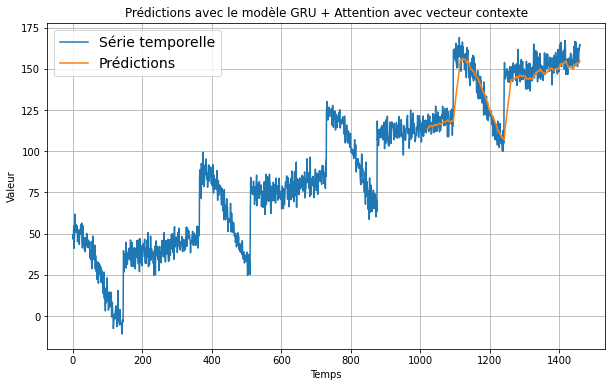

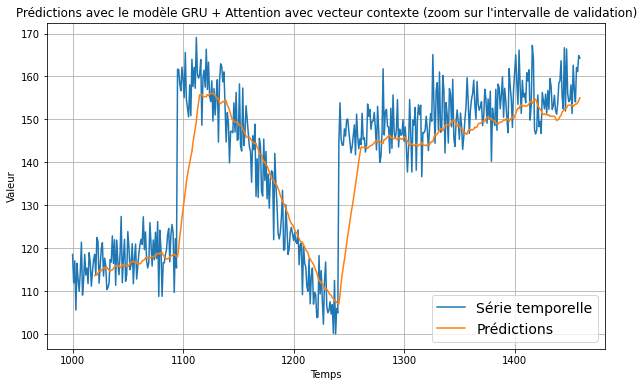

In [23]:
# Affiche la série et les prédictions
plt.figure(figsize=(10, 6))
affiche_serie(temps,serie,label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions*std+mean)[:,0,0],label="Prédictions")
plt.title('Prédictions avec le modèle GRU + Attention avec vecteur contexte')
plt.show()

# Zoom sur l'intervalle de validation
plt.figure(figsize=(10, 6))
affiche_serie(temps[temps_separation:],serie[temps_separation:],label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions*std+mean)[:,0,0],label="Prédictions")
plt.title("Prédictions avec le modèle GRU + Attention avec vecteur contexte (zoom sur l'intervalle de validation)")
plt.show()

In [24]:
# Calcule de l'erreur quadratique moyenne et de l'erreur absolue moyenne 

mae = tf.keras.metrics.mean_absolute_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions*std+mean)[:,0,0]).numpy()
mse = tf.keras.metrics.mean_squared_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions*std+mean)[:,0,0]).numpy()

print(mae)
print(mse)

6.431212901936047
87.38477284183351
